## Preliminary preparations

In [1]:
from datetime import datetime
import os
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import re
import plotly.graph_objects as go
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
pd.set_option('display.max_rows', 100)

In [2]:
experiment = "2048PC"
logfile = "../logs/2048PC/2048PC-2025-03-12-19-21-02-mainnet-beta.log"
csv = "../logs/2048PC/2048PC.csv"

## Preparing Data Source

In [3]:
data = []

with open(logfile, 'r') as file:
    for line in file:
        if "datapoint: replay-slot-stats" in line:

            timestamp_match = re.search(r"\[(.*?)Z", line)
            transactions_match = re.search(r"total_transactions=(\d+)i", line)
            execute_us_match = re.search(r"execute_us=(\d+)i", line)
            
            if timestamp_match and transactions_match and execute_us_match:
                timestamp = timestamp_match.group(1)
                total_transactions_executed = int(transactions_match.group(1))
                execute_us = int(execute_us_match.group(1))

                data.append([timestamp, total_transactions_executed, execute_us])

df = pd.DataFrame(data, columns=['timestamp', 'total_transactions_executed', 'execute_us'])
df

,timestamp,total_transactions_executed,execute_us
0,2025-03-12T20:16:56.414968043,1292,514878
1,2025-03-12T20:16:56.997667578,2307,918963
2,2025-03-12T20:16:57.519772997,1672,516616
3,2025-03-12T20:16:57.844350507,1602,452543
4,2025-03-12T20:16:58.145613524,1271,403375
...,...,...,...
101391,2025-03-13T07:21:00.226795037,1728,625008
101392,2025-03-13T07:21:00.791290627,1605,541607
101393,2025-03-13T07:21:01.265338933,2020,667151
101394,2025-03-13T07:21:01.714377967,1861,671157


In [4]:
program_cache_data = []
program_cache_prune_data = []
loaded_programs_cache_data = []

with open(logfile, 'r') as file:
    for line in file:
        # program_cache_us from replay-slot-stats
        if "datapoint: replay-slot-stats" in line:
            timestamp_match = re.search(r"\[(.*?)Z", line)
            slot_match = re.search(r"slot=(\d+)i", line)
            program_cache_match = re.search(r"program_cache_us=(\d+)i", line)

            if timestamp_match and slot_match and program_cache_match:
                timestamp = timestamp_match.group(1)
                slot = int(slot_match.group(1))
                program_cache_us = int(program_cache_match.group(1))
                program_cache_data.append([timestamp, slot, program_cache_us])

        # program_cache_prune_ms from bank-forks_set_root
        elif "datapoint: bank-forks_set_root" in line:
            timestamp_match = re.search(r"\[(.*?)Z", line)
            slot_match = re.search(r"slot=(\d+)i", line)
            prune_match = re.search(r"program_cache_prune_ms=(\d+)i", line)

            if timestamp_match and slot_match and prune_match:
                timestamp = timestamp_match.group(1)
                slot = int(slot_match.group(1))
                program_cache_prune_ms = int(prune_match.group(1))
                program_cache_prune_data.append([timestamp, slot, program_cache_prune_ms])

        # loaded-programs-cache-stats (all fields)
        elif "datapoint: loaded-programs-cache-stats" in line:
            timestamp_match = re.search(r"\[(.*?)Z", line)
            slot_match = re.search(r"slot=(\d+)i", line)
            if timestamp_match and slot_match:
                timestamp = timestamp_match.group(1)
                slot = int(slot_match.group(1))
                fields = dict(re.findall(r"(\w+)=(-?\d+)i", line))
                fields = {k: int(v) for k, v in fields.items()}
                fields['timestamp'] = timestamp
                fields['slot'] = slot
                loaded_programs_cache_data.append(fields)

# Convert to DataFrames
df_program_cache = pd.DataFrame(program_cache_data, columns=['timestamp', 'slot', 'program_cache_us'])
df_program_cache_prune = pd.DataFrame(program_cache_prune_data, columns=['timestamp', 'slot', 'program_cache_prune_ms'])
df_loaded_programs_cache = pd.DataFrame(loaded_programs_cache_data)

In [5]:
# Show dataframes
# df_program_cache
# print()
# df_program_cache_prune
# print()
df_loaded_programs_cache

,slot,hits,misses,evictions,reloads,insertions,lost_insertions,replace_entry,one_hit_wonders,prunes_orphan,prunes_environment,empty_entries,water_level,timestamp
0,326336110,0,0,0,0,9,0,0,0,0,0,0,0,2025-03-12T20:16:54.803038186
1,326336111,12304,119,0,0,71,0,0,0,0,0,0,71,2025-03-12T20:16:56.436338471
2,326336112,22495,34,0,0,32,0,0,0,0,0,0,103,2025-03-12T20:16:57.032182123
3,326336113,16091,17,0,0,17,0,0,0,0,0,0,120,2025-03-12T20:16:57.530464269
4,326336114,15290,6,0,0,6,0,0,0,0,0,0,126,2025-03-12T20:16:57.864830494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101421,326437718,17099,0,0,0,0,0,0,0,0,0,0,0,2025-03-13T07:21:00.245844722
101422,326437719,15887,0,0,0,0,0,0,0,0,0,0,0,2025-03-13T07:21:00.807500196
101423,326437720,20214,0,0,0,0,0,0,0,0,0,0,0,2025-03-13T07:21:01.286067295
101424,326437721,18947,0,0,0,0,0,0,0,0,0,0,0,2025-03-13T07:21:01.733828559


In [6]:
def convert_to_unixtime(timestamp):
    base_time, microseconds = timestamp.split('.')
    microseconds = microseconds[:6]
    dt = datetime.strptime(base_time, '%Y-%m-%dT%H:%M:%S')
    return int(dt.timestamp() * 1_000_000) + int(microseconds)

In [7]:
df['end'] = df['timestamp'].apply(convert_to_unixtime)
df['start'] = df['end'] - df['execute_us']
df['tps'] = df['total_transactions_executed'] * 1000000 / df['execute_us']
df

# Apply to program_cache DataFrame
df_program_cache['end'] = df_program_cache['timestamp'].apply(convert_to_unixtime)
df_program_cache['start'] = df_program_cache['end'] - df_program_cache['program_cache_us']
df_program_cache['duration_us'] = df_program_cache['program_cache_us']

# Apply to program_cache_prune DataFrame (convert ms to us)
df_program_cache_prune['end'] = df_program_cache_prune['timestamp'].apply(convert_to_unixtime)
df_program_cache_prune['start'] = df_program_cache_prune['end'] - df_program_cache_prune['program_cache_prune_ms'] * 1000
df_program_cache_prune['duration_us'] = df_program_cache_prune['program_cache_prune_ms'] * 1000

# Apply to loaded_programs_cache DataFrame — just convert timestamps for now
df_loaded_programs_cache['unixtime_us'] = df_loaded_programs_cache['timestamp'].apply(convert_to_unixtime)

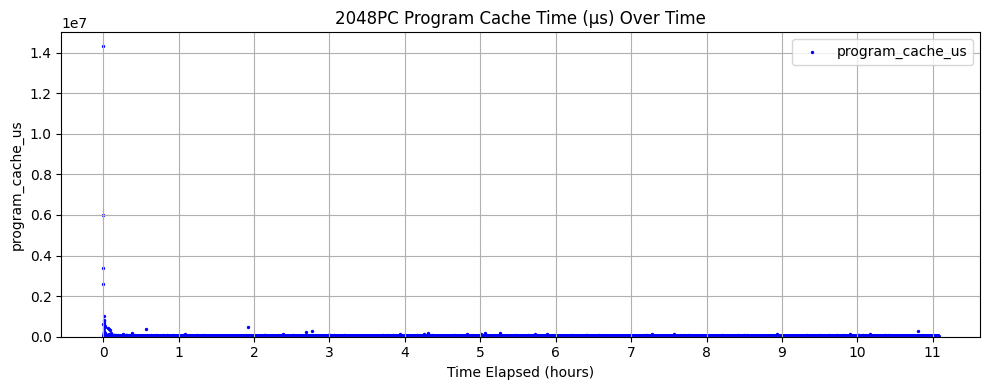

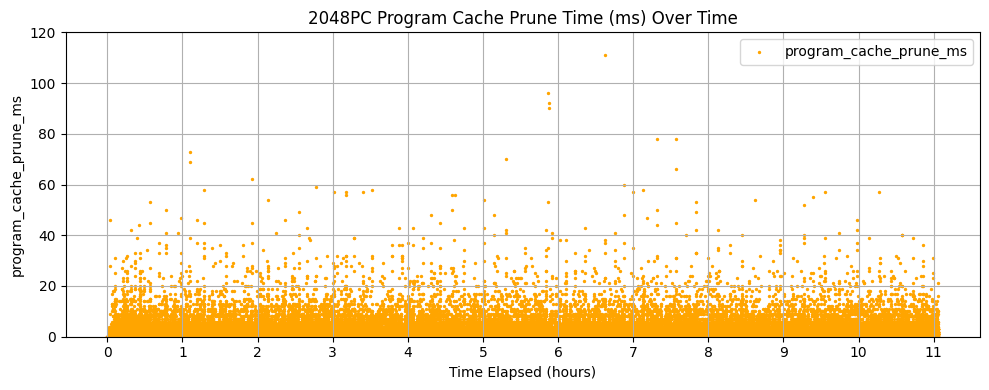

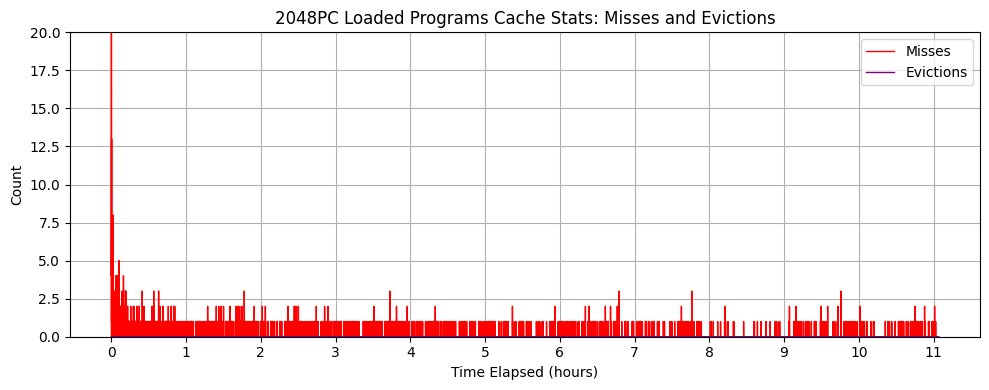

In [8]:
def add_elapsed_time_column(df, time_col='start'):
    base_time = df[time_col].min()
    df['elapsed_time_hours'] = (df[time_col] - base_time) / 3_600_000_000  # µs to hours

add_elapsed_time_column(df_program_cache, time_col='start')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.scatter(df_program_cache['elapsed_time_hours'], df_program_cache['program_cache_us'], s=2, color='blue', label='program_cache_us')
plt.title(experiment + ' Program Cache Time (µs) Over Time')
plt.xlabel('Time Elapsed (hours)')
plt.ylabel('program_cache_us')
plt.ylim(0, 15_000_000)
plt.xticks(ticks=range(int(df_program_cache['elapsed_time_hours'].min()), int(df_program_cache['elapsed_time_hours'].max()) + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

add_elapsed_time_column(df_program_cache_prune, time_col='start')

plt.figure(figsize=(10, 4))
plt.scatter(df_program_cache_prune['elapsed_time_hours'], df_program_cache_prune['program_cache_prune_ms'], s=2, color='orange', label='program_cache_prune_ms')
plt.title(experiment + ' Program Cache Prune Time (ms) Over Time')
plt.xlabel('Time Elapsed (hours)')
plt.ylabel('program_cache_prune_ms')
plt.ylim(0, 120)
plt.xticks(ticks=range(int(df_program_cache_prune['elapsed_time_hours'].min()), int(df_program_cache_prune['elapsed_time_hours'].max()) + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

add_elapsed_time_column(df_loaded_programs_cache, time_col='unixtime_us')

plt.figure(figsize=(10, 4))
plt.plot(df_loaded_programs_cache['elapsed_time_hours'], df_loaded_programs_cache['misses'], label='Misses', color='red', linewidth=1)
plt.plot(df_loaded_programs_cache['elapsed_time_hours'], df_loaded_programs_cache['evictions'], label='Evictions', color='purple', linewidth=1)
plt.title(experiment + ' Loaded Programs Cache Stats: Misses and Evictions')
plt.xlabel('Time Elapsed (hours)')
plt.ylabel('Count')
plt.ylim(0, 20)
plt.xticks(ticks=range(int(df_loaded_programs_cache['elapsed_time_hours'].min()), int(df_loaded_programs_cache['elapsed_time_hours'].max()) + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
print("📊 " + experiment + " program_cache_us:")
print(f"  Min:     {df_program_cache['program_cache_us'].min():,} µs")
print(f"  Max:     {df_program_cache['program_cache_us'].max():,} µs")
print(f"  Average: {df_program_cache['program_cache_us'].mean():,.2f} µs")
print(f"  Total:   {df_program_cache['program_cache_us'].sum():,} µs ({df_program_cache['program_cache_us'].sum() / 1_000_000:.2f} sec)")

print("📊 " + experiment + " program_cache_prune_ms:")
print(f"  Min:     {df_program_cache_prune['program_cache_prune_ms'].min():,} ms")
print(f"  Max:     {df_program_cache_prune['program_cache_prune_ms'].max():,} ms")
print(f"  Average: {df_program_cache_prune['program_cache_prune_ms'].mean():,.2f} ms")

print("📊 " + experiment + " loaded-programs-cache-stats:")

misses = df_loaded_programs_cache['misses']
evictions = df_loaded_programs_cache['evictions']

print(f"  Misses:")
print(f"    Min:     {misses.min():,}")
print(f"    Max:     {misses.max():,}")
print(f"    Average: {misses.mean():,.2f}")

print(f"  Evictions:")
print(f"    Min:     {evictions.min():,}")
print(f"    Max:     {evictions.max():,}")
print(f"    Average: {evictions.mean():,.2f}")

📊 2048PC program_cache_us:
  Min:     0 µs
  Max:     14,316,800 µs
  Average: 13,984.30 µs
  Total:   1,417,951,905 µs (1417.95 sec)
📊 2048PC program_cache_prune_ms:
  Min:     0 ms
  Max:     111 ms
  Average: 1.79 ms
📊 2048PC loaded-programs-cache-stats:
  Misses:
    Min:     0
    Max:     119
    Average: 0.02
  Evictions:
    Min:     0
    Max:     0
    Average: 0.00


In [10]:
start_time = df.start.min() // 1000000 * 1000000
end_time = (df.start.max() + 1000000) // 1000000 * 1000000
time_step = 100000 # 10,000 microsends = .1 second

time_series = pd.DataFrame({
    't': np.arange(start_time, end_time + time_step, time_step)
})

def aggregate_tps(row, df):
    mask = (df['start'] <= row['t']) & (df['end'] >= row['t'])
    return df.loc[mask, 'tps'].sum()

time_series['sum_tps'] = time_series.apply(aggregate_tps, axis=1, df=df)
# window=10 means creating a moving average with the past 1 second's data. If you change it to 100, it would be the past 10 seconds
time_series['moving_average'] = time_series['sum_tps'].rolling(window=50, min_periods=1).mean()
time_series.to_csv(csv, index=False)


In [11]:
# Calculate the maximum TPS
max_tps = time_series['sum_tps'].max()

# Calculate the overall average TPS
average_tps = time_series['sum_tps'].mean()

# Print the results
print(f"Maximum TPS: {max_tps:,.2f}")
print(f"Average TPS: {average_tps:,.2f}")

# Convert the max TPS x-coordinate to the corresponding time
max_tps_time = time_series.loc[time_series['sum_tps'].idxmax(), 't']

# Calculate the total duration spent with 0 TPS
time_with_zero_tps = time_series[time_series['sum_tps'] == 0]
total_time_zero_tps = len(time_with_zero_tps) * time_step / 1_000_000  # Convert microseconds to seconds
total_time_zero_tps_hours = total_time_zero_tps / 3600  # Convert seconds to hours

print(f"Total time spent with 0 TPS: {total_time_zero_tps:.2f} seconds ({total_time_zero_tps_hours:.2f} hours)")

Maximum TPS: 74,776.66
Average TPS: 4,339.02
Total time spent with 0 TPS: 10493.50 seconds (2.91 hours)


In [12]:
# Display every 10 seconds
filtered_time_series = time_series[time_series['t'] % 10000000 == 0]
# from micro sec to sec
filtered_time_series['t'] = np.floor(filtered_time_series['t'] / 1000000)

filtered_time_series

,t,sum_tps,moving_average
50,1.741836e+09,2531.501396,3126.292278
150,1.741836e+09,2745.162254,3437.062291
250,1.741836e+09,0.000000,3924.135249
350,1.741836e+09,2824.548465,3796.467549
450,1.741836e+09,3336.005069,3896.919744
...,...,...,...
398050,1.741876e+09,4268.350264,3569.839494
398150,1.741876e+09,5719.953062,4126.119188
398250,1.741876e+09,7584.365071,4563.670753
398350,1.741876e+09,6678.151337,4692.643008


In [13]:
# Calculate time elapsed in seconds from the start of the log
start_time = filtered_time_series['t'].min()  # First timestamp
filtered_time_series['elapsed_time'] = filtered_time_series['t'] - start_time
filtered_time_series['elapsed_time_hours'] = filtered_time_series['elapsed_time'] / 3600

# Convert elapsed time to HH:MM:SS format
filtered_time_series['elapsed_time_formatted'] = filtered_time_series['elapsed_time'].apply(
    lambda x: f"{int(x // 3600):02}:{int((x % 3600) // 60):02}:{int(x % 60):02}"
)

In [14]:
# Determine the range for the x-axis
x_min = filtered_time_series['elapsed_time_hours'].min() - 1  # One hour before the first data point
x_max = filtered_time_series['elapsed_time_hours'].max() + 1  # One hour after the last data point

fig = go.Figure()

fig.add_trace(go.Scatter(x=filtered_time_series['elapsed_time_hours'], y=filtered_time_series['sum_tps'], mode='markers', name='TPS', marker=dict(size=2)))
fig.add_trace(go.Scatter(x=filtered_time_series['elapsed_time_hours'], y=filtered_time_series['moving_average'], mode='lines', name='TPS Moving Average(1sec)', line=dict(width=0.5)))

# Add horizontal lines for max and average TPS
fig.add_hline(y=average_tps, line_dash="dot", line_color="green", annotation_text=f"Average TPS: {average_tps:.2f}", annotation_position="bottom right")
fig.add_hline(y=max_tps, line_dash="dash", line_color="red", annotation_text=f"Max TPS: {max_tps:.2f}", annotation_position="top right")

fig.update_layout(
    title=f"2048 PC TPS Over Time | Total Time with 0 TPS: {total_time_zero_tps:.2f} seconds ({total_time_zero_tps_hours:.2f} hours) | Max TPS: {max_tps:,.2f}",
    xaxis_title="Time Elapsed (hours)",
    yaxis_title="TPS",
    xaxis=dict(
        tickmode='linear',
        dtick=1,
        tickformat=".1f",
        range=[x_min, x_max]
    ),
    yaxis=dict(range=[0, 15000])
)


fig.show()


In [15]:
# window_size = 50  # Adjust the window size as needed
# time_series['variance'] = time_series['sum_tps'].rolling(window=window_size, min_periods=1).var()
# time_series['std_dev'] = time_series['sum_tps'].rolling(window=window_size, min_periods=1).std()

# # Create a new plot
# fig = go.Figure()

# # # Add TPS line
# # fig.add_trace(
# #     go.Scatter(
# #         x=time_series.index,
# #         y=time_series['sum_tps'],
# #         mode='lines',
# #         name='TPS',
# #         line=dict(color='blue')
# #     )
# # )

# # Add shaded region for standard deviation
# fig.add_trace(
#     go.Scatter(
#         x=pd.concat([pd.Series(time_series.index), pd.Series(time_series.index[::-1])]),
#         y=pd.concat([time_series['sum_tps'] + time_series['std_dev'], 
#                      (time_series['sum_tps'] - time_series['std_dev'])[::-1]]),
#         fill='toself',
#         fillcolor='rgba(135, 206, 250, 1)',  # Light blue shade
#         line=dict(color='rgba(255,255,255,0)'),
#         name='Standard Deviation'
#     )
# )

# # # Add variance as a separate line (optional)
# # fig.add_trace(
# #     go.Scatter(
# #         x=time_series.index,
# #         y=time_series['variance'],
# #         mode='lines',
# #         name='Variance',
# #         line=dict(dash='dot', color='orange')
# #     )
# # )

# # Update layout
# fig.update_layout(
#     title="TPS with Variance and Standard Deviation",
#     xaxis_title="Time",
#     yaxis_title="TPS",
#     template="plotly_white",
#     legend_title="Metrics"
# )

# fig.show()


## Notes
 - If all data points are plotted on the graph, the points and lines become indistinguishable, so I plot them every 10 seconds.
 - TPS values above 15000 are excluded as outliers.
